In [38]:
# preprocesssing libraries
import pandas as pd
import numpy as np

# sklearn data manipulation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    plot_confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)

# catboost classifier
from xgboost import XGBClassifier,XGBRFClassifier,plot_importance

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [39]:
location = "data/"

In [40]:
def read_data(loc, filename):
    df_in = pd.read_csv(loc + filename)
    return df_in

In [41]:
df_train = read_data(location, "Train.csv")
df_test = read_data(location, "Test.csv")
df_ss = read_data(location, "sample_submission.csv")

In [42]:
df_train.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


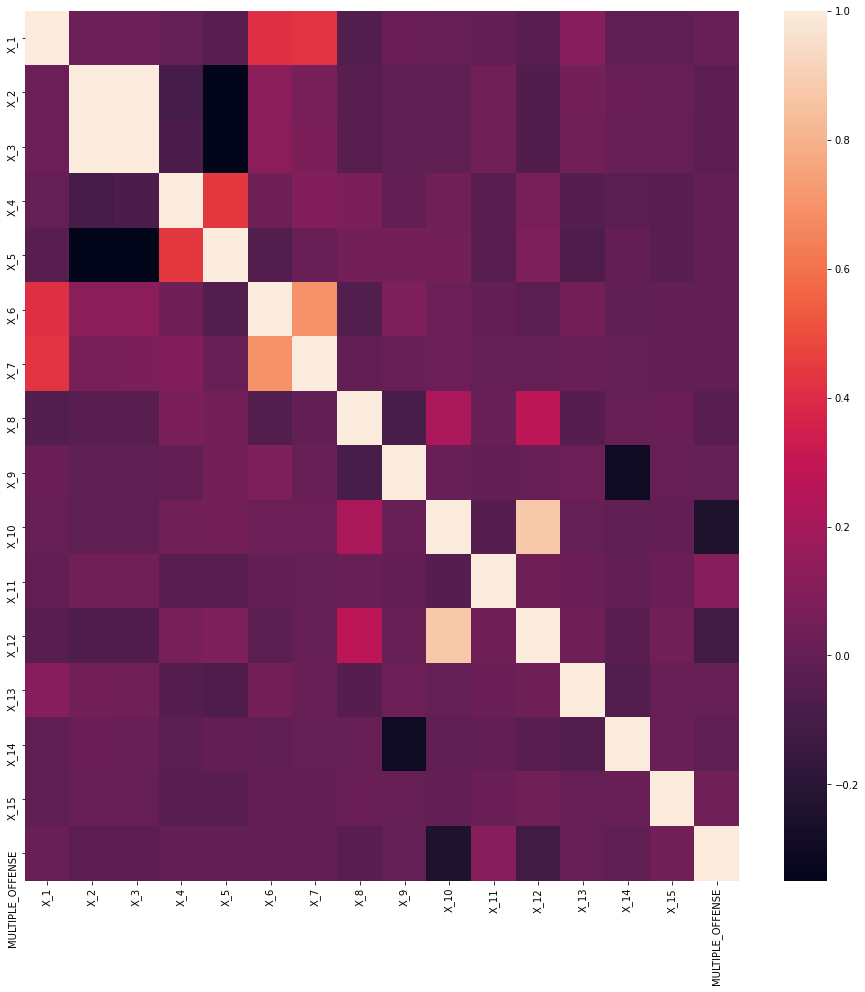

In [43]:
plt.figure(figsize=(16, 16))
sns.heatmap(df_train.corr())
plt.show()

In [44]:
## replace unknown data
def fill_unknown(df, col):
    df[col] = df[col].fillna(-1)
    df[col] = df[col].replace([np.inf, -np.inf], -1)
    df[col] = df[col].astype(int)
    return df

In [45]:
## parse date columns
def todate(df,col):
    df[col] = pd.to_datetime(df[col])
    return df

In [46]:
df_train = fill_unknown(df_train, "X_12")
df_test = fill_unknown(df_test, "X_12")
df_train = todate(df_train, "DATE")
df_test = todate(df_test, "DATE")


In [47]:
df_train["MULTIPLE_OFFENSE"].value_counts()

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64

In [48]:
X = df_train.drop(["INCIDENT_ID", "MULTIPLE_OFFENSE"], axis=1)
y = df_train[["MULTIPLE_OFFENSE"]]

test = df_test.drop(["INCIDENT_ID"], axis=1)
df_sub = df_test[["INCIDENT_ID"]]

# 	x_train = x
# 	y_train = y
# 	x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=22

In [49]:
## Adding features
def feature_engg(df):
    df["srday"] = df["DATE"].dt.day
    df["srmon"] = df["DATE"].dt.month

    ## binning days
    df.loc[df["srday"] <= 10, "day_buc"] = 1
    df.loc[(df["srday"] > 10) & (df["srday"] <= 20), "day_buc"] = 2
    df.loc[df["srday"] > 20, "day_buc"] = 3

    ## binning months into quarter
    df.loc[df["srmon"] <= 3, "quarter"] = 1
    df.loc[(df["srmon"] > 3) & (df["srmon"] <= 6), "quarter"] = 2
    df.loc[(df["srmon"] > 6) & (df["srmon"] <= 9), "quarter"] = 3
    df.loc[df["srmon"] > 9, "quarter"] = 4
    
    df['day_buc'] = df['day_buc'].astype(int)
    df['quarter'] = df['quarter'].astype(int)

    ## clubbing of low imp features in model
    #     df['combo'] = df['X_3'].astype(str) + df['X_6'].astype(str)
    #     df['combo'] = df['combo'].astype(int)

    ## drop correlated and low imp features
    df.drop(
        ["DATE", "X_1", "X_3", "X_6", "X_8", "srmon"],
        axis=1,
        inplace=True,
    )
    return df

In [50]:
X = feature_engg(X)
test = feature_engg(test)

X.head()

,X_2,X_4,X_5,X_7,X_9,X_10,X_11,X_12,X_13,X_14,X_15,srday,day_buc,quarter
0,36,2,1,6,6,1,174,1,92,29,36,4,1,3
1,37,0,0,17,6,1,236,1,103,142,34,18,2,3
2,3,3,5,0,3,1,174,1,110,93,34,15,2,1
3,33,2,1,1,6,1,249,1,72,29,34,13,2,1
4,33,2,1,3,5,1,174,0,112,29,43,13,2,2


In [51]:
X.dtypes

X_2        int64
X_4        int64
X_5        int64
X_7        int64
X_9        int64
X_10       int64
X_11       int64
X_12       int64
X_13       int64
X_14       int64
X_15       int64
srday      int64
day_buc    int64
quarter    int64
dtype: object

In [52]:
X.shape

(23856, 14)

In [53]:
cat_features_ids = [0, 2, 3, 4, 5, 6, 11, 12, 13]

In [54]:
def display_importances(feature_importance_df_):
    cols = (
        feature_importance_df_[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:40]
        .index
    )
    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)
    ]
    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title("LightGBM Features")
    plt.tight_layout()

In [21]:
def get_metric_and_best_threshold_from_roc_curve(
    tpr, fpr, thresholds, num_pos_class, num_neg_class
):
    tp = tpr * num_pos_class
    tn = (1 - fpr) * num_neg_class
    acc = (tp + tn) / (num_pos_class + num_neg_class)

    best_threshold = thresholds[np.argmax(acc)]
    return np.amax(acc), best_threshold


def get_metric_and_best_threshold_from_pr_curve(
    precision, recall, thresholds, num_pos_class, num_neg_class
):
    tp = recall * num_pos_class
    fp = (tp / precision) - tp
    tn = num_neg_class - fp
    acc = (tp + tn) / (num_pos_class + num_neg_class)

    best_threshold = thresholds[np.argmax(acc)]
    return np.amax(acc), best_threshold

In [22]:
max_recall, best_thres = get_metric_and_best_threshold_from_pr_curve(
    prec, rec, thres, 1, 1
)
print("Max Recall: ", max_recall)
print("Best Threshold: ", best_thres)

Max Recall:  0.9997806055287407
Best Threshold:  1.0


In [23]:
## Get average of predict proba and apply best threshold for binary classification
df_sub["MULTIPLE_OFFENSE_sum"] = (
    df_sub["MULTIPLE_OFFENSE1"]
    + df_sub["MULTIPLE_OFFENSE2"]
    + df_sub["MULTIPLE_OFFENSE3"]
    + df_sub["MULTIPLE_OFFENSE4"]
    + df_sub["MULTIPLE_OFFENSE5"]
)

df_sub["MULTIPLE_OFFENSE"] = df_sub["MULTIPLE_OFFENSE_sum"].apply(
    lambda x: 1 if x / 5 >= best_thres else 0
)

In [24]:
df_finalsub = df_sub[["INCIDENT_ID", "MULTIPLE_OFFENSE"]]
df_finalsub["MULTIPLE_OFFENSE"].value_counts()

1    15173
0      730
Name: MULTIPLE_OFFENSE, dtype: int64

In [25]:
df_finalsub.to_csv("highest_submission_21.csv", index=False)